In [3]:
import random
import torch
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn import preprocessing
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
def fix_random(seed: int) -> None:
    """Fix all the possible sources of randomness.

    Args:
        seed: the seed to use.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True  # slower

In [5]:
SEED =1038893

fix_random(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

root = "../../data/ml-25m"

Device: cpu


## Data Acquisition

In [6]:
def get_data_from_csv(file: str, nrows=None):
    if nrows:
        df = pd.read_csv(f"{root}/{file}", nrows=nrows)
    else:
        df = pd.read_csv(f"{root}/{file}")
    print(f"Loaded ml-25m data: {root}/{file}")

    return df

def get_movies_from_csv(nrows=None):
    path = "movies.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)
    print(data.head())
    return data

def get_ratings_from_csv(nrows=None):
    path = "ratings.csv"

    data = get_data_from_csv(path, nrows)
    # data = get_data_from_csv(path)

    data.drop("timestamp", axis=1, inplace=True)
    # todo: drop user id
    #data.drop("userId", axis=1, inplace=True)

    return data

def get_tag_relevances_from_csv(nrows=None):
    path = "genome-scores.csv"

    return get_data_from_csv(path, nrows)

In [7]:
genome_scores_path = "genome-scores.csv"
ratings_path = "ratings.csv"

In [8]:
ratings = get_ratings_from_csv()
movies = get_movies_from_csv()
print(ratings)

Loaded ml-25m data: ../../data/ml-25m/ratings.csv
Loaded ml-25m data: ../../data/ml-25m/movies.csv
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
          userId  movieId  rating
0              1      296     5.0
1              1      306     3.5
2              1      307     5.0
3              1      665     5.0
4              1      899     3.5
...          ...      ...     ...
25000090  162541    50872     4.5
25000091  162541    55768     2.5


In [9]:
genome_scores = get_tag_relevances_from_csv()
print(genome_scores)

Loaded ml-25m data: ../../data/ml-25m/genome-scores.csv
          movieId  tagId  relevance
0               1      1    0.02875
1               1      2    0.02375
2               1      3    0.06250
3               1      4    0.07575
4               1      5    0.14075
...           ...    ...        ...
15584443   206499   1124    0.11000
15584444   206499   1125    0.04850
15584445   206499   1126    0.01325
15584446   206499   1127    0.14025
15584447   206499   1128    0.03350

[15584448 rows x 3 columns]


In [10]:
# films = get_data_from_csv(f"{root}/{ratings}")[]


# DATA VISUALIZATION


In [11]:
            # # Fill in missing values with zeros
            # X.fillna(0, inplace=True)


# FARE TEST CON AVG, STD_DEV

In [12]:
def addColumnOperation(ratings,X):
     # Compute the mean rating for each user
     count_rating = ratings.groupby('movieId', as_index=False)['rating'].count()
     std= ratings.groupby('movieId', as_index=False)['rating'].std()
     std.fillna(0, inplace=True)
     min_ratings= ratings.groupby('movieId', as_index=False)['rating'].min()
     max_ratings= ratings.groupby('movieId', as_index=False)['rating'].max()
     median= ratings.groupby('movieId', as_index=False)['rating'].median()
     operation = pd.DataFrame({'movieId':count_rating['movieId'],'count_rating': count_rating['rating'], 'std': std['rating'], 'min': min_ratings['rating'], 'max': max_ratings['rating'], 'median': median['rating']}) 
     X = pd.merge(X, operation, on='movieId')
     return X
    
def preprocessing1(relevance, ratings):
     # Reduce genome-score size
     # Pivot the relevance DataFrame to create a matrix of tag relevance scores for each movie
     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     counting = relevance.groupby('movieId', as_index=False)['relevance'].count()
     print(counting)
     # Merge the ratings and relevance data
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     X = mean_ratings.merge(relevance_matrix, on='movieId')
     #X = addColumnOperation(ratings,X)
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     return X,y

def preprocessing2(movies,relevance, ratings):
     # Merge the ratings and movies data
     #X = ratings.merge(movies, on='movieId')
     movies_genres = movies['genres'].str.split( '|')
     m = pd.get_dummies(movies_genres.apply(pd.Series).stack()).sum(level=0)
     movies_genres = pd.concat([movies['movieId'], m], axis=1)

     relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
     mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
     
     X = mean_ratings.merge(movies_genres, on='movieId')
     X = X.merge(relevance_matrix, on='movieId')
     X.columns = X.columns.astype(str)
     ratings = None  
     # mescolare le righe del DataFrame
     #X = X.sample(frac=1).reset_index(drop=True)
     
     y = X['rating']
     X.drop("movieId", axis=1, inplace=True)
     X = X.drop('rating', axis=1)
     
     # Apply PCA if n_components is specified
     pca = PCA()
     X = pca.fit_transform(X)
     return X,y

In [24]:
class LinearRegressionModel:
    def __init__(self, ratings,movies,relevance, seed=1038893):
        import matplotlib.pyplot as plt
        relevance_matrix = relevance.pivot_table(index='movieId', columns='tagId', values='relevance', fill_value=0)
        
        
        # Merge the ratings and relevance data
        mean_ratings = ratings.groupby('movieId', as_index=False)['rating'].mean()
        X = mean_ratings.merge(relevance_matrix, on='movieId')
        X.columns = X.columns.astype(str)
        
        ratings = None  

        # mescolare le righe del DataFrame
        X = X.sample(frac=1,random_state=seed).reset_index(drop=True)
        
        y = X['rating']
        X.drop("movieId", axis=1, inplace=True)
        X = X.drop('rating', axis=1)
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
        print(self.X_train.shape, self.X_test.shape, self.y_train.shape, self.y_test.shape)

        pca = PCA(n_components=0.95)
        pca.fit(self.X_train)
        self.X_train_t = pca.transform(self.X_train)
        self.X_test_t = pca.transform(self.X_test)
        #print(self.X_train)
        #print(self.X_train_t)
        plt.scatter(self.X_train_t[:, 0], self.X_train_t[:, 1], c=self.y_train, cmap='viridis')
        plt.show()
        
        plt.scatter(self.X_test_t[:, 0], self.X_test_t[:, 1], c=self.y_test, cmap='viridis')
        plt.show()
       
        self.model = RidgeCV(alphas=(0.1,0.5,1.0,2.5,5,6,10),cv=3)    

    def evaluate(self):
        # Fit the model to the training data

        
        self.model.fit(self.X_train, self.y_train)
        print(f"Alpha:{self.model.alpha_}")
        print("Modello fittato senza PCA transformation")
        self.test(self.X_test)
        
        self.model = RidgeCV(alphas=(0.1,0.5,1.0,2.5,5,6,10),cv=3)
        #self.tuning(self.X_train_t, self.y_train)
        self.model.fit(self.X_train_t, self.y_train)
        print(f"Alpha:{self.model.alpha_}")
        print("Modello fittato con PCA transformation")
        #print(self.model.alpha_)
        self.test(self.X_test_t)
    

    def test(self, X_test):
        # Predict ratings for the test data
        y_pred = self.model.predict(X_test)

        # Compute the mean squared error
        mse = mean_squared_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        mae = mean_absolute_error(self.y_test, y_pred)

        print(f"MSE: {mse} RMSE: {rmse} R2: {r2} MAE: {mae}")
        score = self.model.score(X_test, self.y_test)
        print(f"Score:{score}")
        print("Intercept: "+str( self.model.intercept_))
        print("Coefficients: "+ str(self.model.coef_))


(11052, 1128) (2764, 1128) (11052,) (2764,)


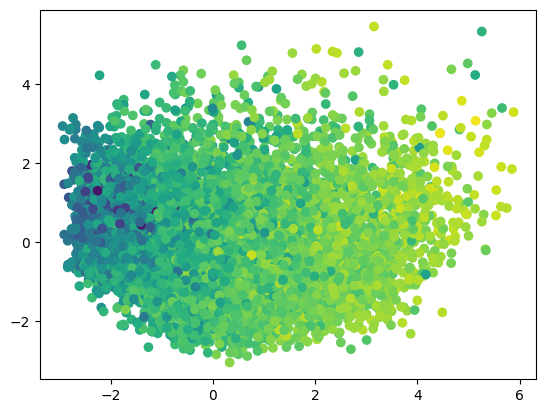

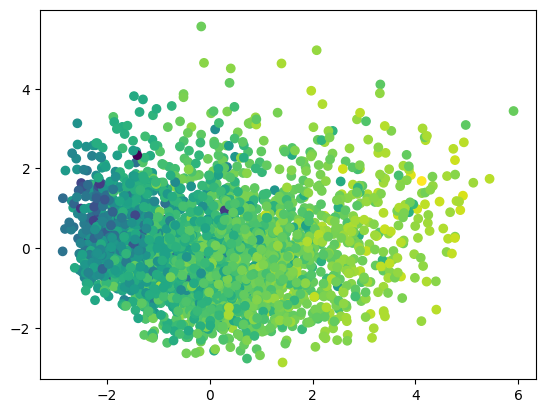

In [25]:
lr = LinearRegressionModel(ratings,movies,genome_scores, SEED)

In [26]:
lr.evaluate()

Alpha:2.5
Modello fittato senza PCA transformation
MSE: 0.005173317239238808 RMSE: 0.0719257759029321 R2: 0.9784230321851388 MAE: 0.05530627637007967
Score:0.9784230321851388
Intercept: 3.5165385346689786
Coefficients: [ 0.00215735 -0.04146859 -0.00141315 ... -0.01846301 -0.10410064
  0.07087317]
Alpha:6.0
Modello fittato con PCA transformation
MSE: 0.0063303117843782316 RMSE: 0.07956325649681661 R2: 0.9735974178050478 MAE: 0.060759651674386066
Score:0.9735974178050478
Intercept: 3.273582484249796
Coefficients: [ 2.18999461e-01 -4.04323750e-02  1.32687292e-01  2.28902495e-02
 -6.15701049e-02  1.16391810e-01  1.62662148e-02  2.13091667e-02
 -4.86954563e-02 -6.54725595e-02  2.32416871e-02 -1.37702630e-01
 -8.14587061e-02  9.18851238e-02  2.19886751e-01  1.00222055e-01
  7.34529402e-02 -1.47995894e-01  1.02688140e-01 -2.81446464e-01
  1.35915958e-01  8.75136661e-02  9.37111039e-02  4.54295745e-02
  2.02496693e-01 -1.61164278e-01  1.09317518e-02  1.29679018e-01
  7.71031219e-02  6.98139906

In [27]:
#lr.test()